# Programming Exercise 2: Logistic Regression

This notebook is based on the [Coursera Machine Learning](https://www.coursera.org/learn/machine-learning) course by Andrew Ng. We believe it is the best course for people who are keen to make their first steps in Machine Learning.

The course is taught in Octave / MATLAB, but Python is much more broadly used in the industry and academia. We have used and modified a Python implementation from [David Kaleko](https://github.com/kaleko). 

Explanations of the model, and any mistakes herein, are of our own doing. If you're unsure about anything, feel free to ask us during the session!

**Instructions:**
- You can run the notebook at your own pace
- This note book already have evreything filled in. You can just run all the cells if you are not confident in your coding skills, or if you are stuck at the other 2 notebooks and want a sneak peek.
- Ask if you need help

**You will learn to:**
- Play with a toy dataset

- Build one of the simplest machine learning algorithms for classification: Logistic regression

- Apply logistic regression on the toy dataset to predict
    
- Learn how it works and potential caveats

## 1 Packages

First, let's run the cell below to import all the packages that you will need during this assignment. 

In [1]:
# the following line allows us to output plots in the notebook
%matplotlib inline 

import scipy                      # fundamental package that contains all important mathematical functions
import numpy as np                # fundamental package for scientific computing with Python
import pandas as pd               # fundamental dataframe package to wrangle a dataset in tabular form
import matplotlib.pyplot as plt   # famous library to plot graphs in Python

## 2 Overview of the Dataset

### 2.1 Problem Statement

Recall that the task of supervised learning is to train a model to predict a label $y$ given an input $x = (x_1, x_2, \dotsc, x_n)$ based a bunch of labelled examples $\{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \dotsc, (x^{(m)}, y^{(m)})\}$ which we call the **training data**.

In binary classification, the label $y$ can take on two values: $0$ or $1$.
$0$ represents the "negative class" and $1$ represents the "positive class".
Given an input $x$ we would like to know which class it belongs to.
Some examples logistic regression can be applied to are:
- Given an email, predict whether it was "spam" or "not spam"
- Given an online transaction, predict whether it was "fraud" or "not fraud"
- Given a tumor data, predict whether it is "malignant" or "benign"

Suppose that you are the administrator of a university department and you want to determine each applicant’s chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant’s scores on two exams and the admissions decision.

Let's get more familiar with the dataset. Load the data by running the following code.

In [2]:
data = pd.read_csv('data/exam_data.txt', sep = ',', header=None)
data.columns = ['Exam1_score', 'Exam2_score', 'Admitted']

# This is the code to display the top samples in the dataset. You can change number to choose how many to display 
data.head(5)

Exam1_score  Exam2_score  Admitted
0     3.462366     7.802469         0
1     3.028671     4.389500         0
2     3.584741     7.290220         0
3     6.018260     8.630855         1
4     7.903274     7.534438         1

### 2.2 Data Visualization

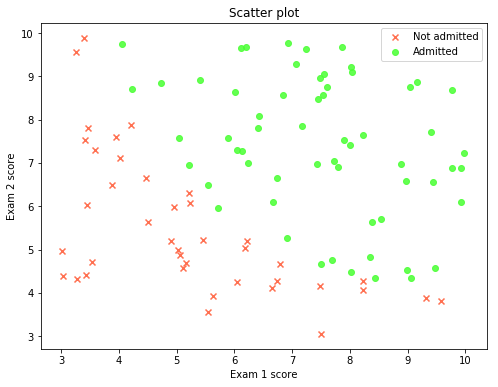

In [3]:
# save the code of plotting into a function for faster plotting later
def plot_data(): 
    fig, ax = plt.subplots(1, 1, figsize = [8, 6])
    # draw
    ax.scatter(data.Exam1_score[data.Admitted == 0], data.Exam2_score[data.Admitted == 0], color='#FF5733', marker = 'x',
                            alpha=0.85, label='Not admitted')
    ax.scatter(data.Exam1_score[data.Admitted == 1], data.Exam2_score[data.Admitted == 1], color='#49FF33', marker = 'o',
                            alpha=0.85, label='Admitted')
    ax.set_xlabel('Exam 1 score')
    ax.set_ylabel('Exam 2 score')
    ax.set_title('Scatter plot')
    ax.legend()
    
plot_data()

In [4]:
# Separating X and y. Just run this cell
X = data[['Exam1_score', 'Exam2_score']].values
y = data['Admitted'].values

print('Shape of matrix X is {}.'.format(X.shape))
print('X has {} samples.'.format(X.shape[0]))
print('X has {} features.'.format(X.shape[1]))

y = y.reshape(-1, 1)

print('Shape of vector y is {}.'.format(y.shape))

Shape of matrix X is (100, 2).
X has 100 samples.
X has 2 features.
Shape of vector y is (100, 1).


Remember from the linreg exercise and the sides, that in order to neatly calculate $\theta_0$ into $\theta$, we add a column of 1s to the left of $X$, to be feature $x_0$? We do it with the following code:

In [5]:
# Don't forget to run this cell
X = np.insert(X, 0, 1, axis=1)

So now, technically, we can say $X$ has 3 features.

## 3 Logistic Regression

Recall that in linear regression, we had a hypothesis $h_{\theta}(x)$ which allowed us to predict any number.
In binary classification, we would like to predict either $0$ or $1$.
For this purpose we will design a function $h_{\theta}(x)$ which will output a number from $0$ to $1$:
- if $h_{\theta}(x) \geq 0.5$, predict "$y = 1$",
- if $h_{\theta}(x) < 0.5$, predict "$y = 0$".

*Quick summary of how we will do logistic regression from slides, step by step:*

- We initialize the parameters ($\theta$)

- Use them to calculate the Cost

- Calculate the gradient
 
- Use the gradient to update parameters in order to reduce the cost

- Keep doing it a lot of times (maybe 10000 times), to obtain the "optimal" theta.

### 3.1 Sigmoid function

We first implement the "sigmoid function" that we will use later.
It takes in a number and squishes it to be between $0$ and $1$.
The sigmoid function has the following form:
$$ \mathrm{sigmoid}(z)=\frac{1}{1+e^{−z}} $$

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [ ]:
# Just run this cell. It will plot the function
z = np.arange(-10, 10, 0.1)
fig, ax = plt.subplots(1, 1)
ax.plot(z, sigmoid(z))
ax.set_xlabel('$z$')
ax.set_ylabel('sigmoid($z$)')
ax.set_title('Sigmoid Function')
ax.grid()

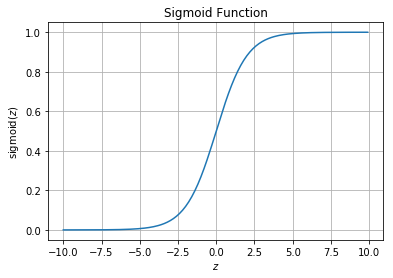

In [8]:
# Here is how it should looks like if you got that correctly. Do not run this cell

In [7]:
# Although, as a matter of fact, we can import the sigmoid function from scipy for better application later. 
# Just run this cell
from scipy.special import expit as sigmoid

*The maths below were already covered in the slides, but we repeat them here to help you review*

### 3.2 Hypothesis Function

Recall that in linear regression the output of the hypothesis function was $\theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n$ where $x = (x_1, x_2, \dotsc, x_n)$ is the input and $\theta = (\theta_0, \theta_1, \dotsc, \theta_n)$ are the parameters.
In logistic regression we slightly modify the hypothesis function to be

\begin{align}
    z_{\theta}(x) &= \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n = \theta^T x && \text{(linear function)}\\
    h_{\theta}(x) &= \mathrm{sigmoid}(z_{\theta}(x)) = \mathrm{sigmoid}(\theta^T x) && \text{(using vector notation)} \\
    &= \frac{1}{1 + e^{-\theta^T x}}. && \text{(using the definition of the sigmoid function)}
\end{align}

Since a sigmoid is a function whose output is between $0$ and $1$, $h_{\theta}(x)$ will also output a number between $0$ and $1$ for a given input $x$.
We can interpret the output of the hypothesis function $h_{\theta}(x)$ to be the probability that $y = 1$ given $x$.

### 3.3 Cost Function

Recall that in linear regression, the cost function was $J(\theta) = \frac{1}{m} \sum_{i = 1}^m \left(\frac{1}{2} (h_{\theta}(x^{(i)}) - y^{(i)})^2\right)$.
We can think of the term $\frac{1}{2} (h_{\theta}(x^{(i)}) - y^{(i)})^2$ as a measure of how close $h_{\theta}(x^{(i)})$ is to $y^{(i)}$.
This works well for linear regression where both $h_{\theta}(x^{(i)})$ and $y^{(i)}$ can be any numbers.

In logistic regression where $h_{\theta}(x^{(i)})$ is between $0$ and $1$ and $y^{(i)}$ can be either $0$ or $1$, this doesn't work very well.
In general, we need to come up with a function $\mathrm{cost}(h_{\theta}(x), y)$ that somehow measures the "closeness" of $h_{\theta}(x)$ to $y$.
The cost function for logistic regression has the following form:

\begin{align}
    \mathrm{cost}(h_{\theta}(x), y) &=
        \begin{cases}
            -\log (h_{\theta}(x)) & \text{if } y = 1 \\
            -\log (1 - h_{\theta}(x)) & \text{if } y = 0.
        \end{cases}
\end{align}

This cost function has a desirable property that (you can check this for yourself!):
- $\mathrm{cost}(h_{\theta}(x), y) = 0$ if $y = 1$ and $h_{\theta}(x) = 1$,
- $\mathrm{cost}(h_{\theta}(x), y) \to \infty$ if $y = 1$ and $h_{\theta}(x) \to 0$,
- $\mathrm{cost}(h_{\theta}(x), y) = 0$ if $y = 0$ and $h_{\theta}(x) = 0$, and
- $\mathrm{cost}(h_{\theta}(x), y) \to \infty$ if $y = 0$ and $h_{\theta}(x) \to 1$.

This means that an algorithm is penalised by $0$ if it gets the classification right, but by a very large cost if it gets it wrong.

### 3.4 Simplified Cost Function

The cost function
\begin{align}
    \mathrm{cost}(h_{\theta}(x), y) &=
        \begin{cases}
            -\log (h_{\theta}(x)) & \text{if } y = 1 \\
            -\log (1 - h_{\theta}(x)) & \text{if } y = 0
        \end{cases}
\end{align}
is quite clunky to work with.

It turns out that we can write it in one expression as
\begin{align}
    \mathrm{cost}(h_{\theta}(x), y) &= -y \log (h_{\theta}(x)) - (1 - y) \log (1 - h_{\theta}(x)).
\end{align}

Check for yourself that, as required:
- if we substitute $y = 1$ to the simplified cost, we obtain $(-\log (h_{\theta}(x)))$ and
- if we substitute $y = 0$ to the simplified cost, we obtain $(-\log (1 - h_{\theta}(x)))$.

Hence, given the training data $\{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \dotsc, (x^{(m)}, y^{(m)})\}$, total cost is:
\begin{align}
    J(\theta) &= \frac{1}{m} \sum_{i = 1}^m \mathrm{cost}(h_{\theta}(x^{(i)}), y^{(i)}) \\
    &= \frac{1}{m} \sum_{i = 1}^m \left[ -y^{(i)} \log (h_{\theta}(x^{(i)})) - (1 - y^{(i)}) \log (1 - h_{\theta}(x^{(i)})) \right]. && \text{(use the simplified cost)}
\end{align}

To find the parameters $\theta$, we will minimize $J(\theta)$ with respect to $\theta$.

After this optimization, to make a prediction given a new $x$, we evaluate
\begin{align}
    h_{\theta}(x) = \frac{1}{1 + e^{-\theta^T x}},
\end{align}
and predict $y = 1$ if $h_{\theta}(x) \geq 0.5$ and predict $y = 0$ if $h_{\theta}(x) < 0.5$.

Your task now is to implement a function that returns $J(\theta)$ given the training data $\{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \dotsc, (x^{(m)}, y^{(m)})\}$ in the form of a matrix $X$ and vector $y$ and the parameter vector $\theta$:
\begin{align}
    X &=
        \begin{bmatrix}
            1 & x_1^{(1)} & x_2^{(1)} & \cdots & x_n^{(1)} \\
            1 & x_1^{(2)} & x_2^{(2)} & \cdots & x_n^{(2)} \\
            \vdots & & \ddots & & \vdots \\
            1 & x_1^{(m)} & x_2^{(m)} & \cdots & x_n^{(m)} \\
        \end{bmatrix} &&\text{and}\\
    y &= 
        \begin{bmatrix}
            y^{(1)} \\
            y^{(2)} \\
            \vdots \\
            y^{(m)}
        \end{bmatrix},
\end{align}
where $n$ is the number of features and $m$ is the number of examples.

In [8]:
def calculate_cost(X, y, theta):
    """
    Implement the cost function explained above.

    Arguments:
    X -- training data, of size (number of samples, number of features)
    y -- true "label" vector, of size (number of samples, 1)
    theta -- weights, of size (number of features, 1)

    Return:
    cost -- cost for logistic regression, a scalar
    """
    m, n = X.shape          # m is number of samples, n is number of features
    
    Z = X @ theta           # linear function above. @ is a Python operator for matrix multiplication, 
                            # it behaves similar to np.matmul or np.dot with 2D arrays. A @ B is np.matmul(A,B)
    H = sigmoid(Z)
    
    cost = -np.mean(y * np.log(H) + (1 - y) * np.log(1 - H))
    
    return cost

In [ ]:
# Run this cell and compared your output to the expected output
theta = np.zeros((3, 1))    # initialize theta to be all 0s
calculate_cost(X, y, theta)

**Expected Output**: 



<table>
  <tr>
    <td>**Cost**</td>
    <td> 0.69314718055994529</td> 
  </tr>
</table>


### 3.5 Gradient of the Cost Function

In order to perform gradient descent on the total cost $J(\theta)$ we need to calculate the partial derivatives of $J(\theta)$ with respect to each $\theta_j$.

The derivative of the cost function turns out to be
\begin{align}
    \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i = 1}^m (h_{\theta}(x^{(i)}) - y^{(i)}) x_j^{(i)}.
\end{align}

You can derive this for yourself but for now, just take this on trust.

Given the vectorised representation of the training data, we can calculate all the partial derivatives at once.
The resulting vector of partial derivatives is called the gradient of $J(\theta)$ with respect to $\theta$, denoted $\nabla_{\theta} J$:
\begin{align}
    \nabla_{\theta} J =
    \begin{bmatrix}
        \frac{\partial J(\theta)}{\partial \theta_0} \\
        \frac{\partial J(\theta)}{\partial \theta_1} \\
        \vdots \\
        \frac{\partial J(\theta)}{\partial \theta_n}
    \end{bmatrix} =
    \frac{1}{m} X^T (H - y),
\end{align}
where $H$ is a vector of the hypothesis outputs:
\begin{align}
    H =
    \begin{bmatrix}
        h_{\theta}(x^{(1)}) \\
        h_{\theta}(x^{(2)}) \\
        \vdots \\
        h_{\theta}(x^{(m)})
    \end{bmatrix}.
\end{align}

Your task now is to implement a function that takes in a matrix $X$, a vector $y$, and a vector $\theta$ and returns the vector $\nabla_{\theta} J(\theta)$.

In [9]:
def calculate_gradient(X, y, theta):
    """
    Implement the gradient function above.
    
    Arguments: same as calculate_cost function
    
    Return:
    dtheta: a vector holding the gradient for all theta_j, of size (number of features, 1)
    """
    m, n = X.shape
    
    Z = X @ theta
    H = sigmoid(Z)
    
    dtheta = (1. / m) * X.T @ (H - y)
    
    assert dtheta.shape == (n, 1)
    
    return dtheta

In [ ]:
# Run this cell and compared your output to the expected output
theta = np.zeros((3, 1))
calculate_gradient(X, y, theta)

**Expected Output**: 



<table>
  <tr>
    <td>**Gradients for theta**</td>
    <td> -0.1 &emsp; -1.20092166 &emsp; -1.12628422</td> 
  </tr>
</table>


### 3.6 Optimization of $J(\theta)$

We are now ready to perform gradient descent to minimize $J(\theta)$ with respect to $\theta$.
The pseudocode for gradient is simply:
- Initialize $\theta$
- Repeat until convergence:
    - Update $\theta_j = \theta_j - \alpha \cdot \frac{\partial J(\theta)}{\partial \theta_j}$ for all $\theta_j$
where $\alpha$ is the learning rate.

In the vectorized form, it would be:
- Initialize $\theta$
- Repeat until convergence:
    - Update $\theta = \theta - \alpha \cdot \nabla_{\theta} J(\theta)$

In [ ]:
num_iterations = 10000
learning_rate = 0.1
theta = np.ones((3,1))
cost_history = np.zeros(num_iterations)

for i in range(num_iterations):
    dtheta = calculate_gradient(X, y, theta)
    theta = theta - learning_rate * dtheta
    cost_history[i] = calculate_cost(X, y, theta)

theta_optimal = theta.copy()    
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Gradient descent step')
ax.set_ylabel('$J(\\theta)$')
ax.grid(True)
ax.plot(cost_history)
plt.show()

In [ ]:
# Run this cell and compared your output to the expected output
print('The final theta is: \n {}'.format(theta_optimal))

**Expected Output**: 



<table>
  <tr>
    <td>**Optimal theta**</td>
    <td> -15.26656328 &emsp; 1.27230783 &emsp; 1.21435648</td> 
  </tr>
</table>


### 3.7 Make predictions

In [10]:
def predict(X, theta):
    """
    Predict label of X using parameters theta.
    
    Return:
    y_hat -- predicted value given X, of size (number of samples, 1)
    """
    m, n = X.shape
    Z = X @ theta                   
    H = sigmoid(Z)
    
    y_hat = np.zeros((m, 1))
    y_hat[H >= 0.5] = 1.
    y_hat[H < 0.5] = 0.
            
    return y_hat

In [ ]:
# Run this cell and compared your output to the expected output
train_accuracy = np.mean(1 - np.abs(predict(X, theta_optimal) - y))
print('Train accuracy: {} %'.format(train_accuracy * 100))

**Expected Output**: 



<table>
  <tr>
    <td>**Train accuracy**</td>
    <td> 89% </td> 
  </tr>
</table>


### 3.8 Decision Boundary

We can view the decision boundary at final $\theta$.

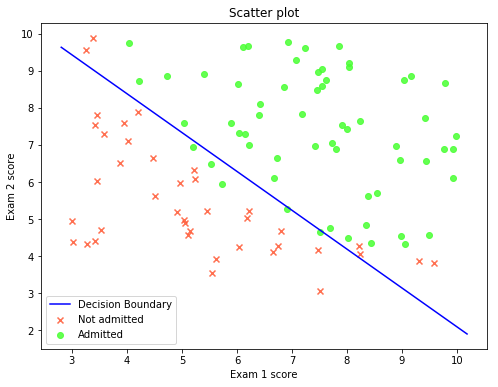

In [38]:
boundary_xs = np.array([np.min(X[:, 1]) - 0.2, np.max(X[:, 1]) + 0.2])
boundary_ys = (-1. / theta_optimal[2]) * (theta_optimal[0] + theta_optimal[1] * boundary_xs)
plot_data()
plt.plot(boundary_xs, boundary_ys, 'b-', label='Decision Boundary')
plt.legend()
plt.show()

## 4 Test Data and Generalization

In Machine Learning, it is important to separate the training dataset and the test dataset. You want to fit a model on the training set and validate the performance on an untampered test set.

Let's load the test dataset by running the cell below.

In [11]:
testdata = pd.read_csv('data/exam_data_test.txt', sep = ',', header=None)
testdata.columns = ['Exam1_score', 'Exam2_score', 'Admitted']

X_test = testdata[['Exam1_score', 'Exam2_score']].values
X_test = np.insert(X_test, 0, 1, axis=1)       # add column of 1s to the left
y_test = testdata['Admitted'].values
y_test = y_test.reshape(-1,1)

In [36]:
test_accuracy = np.mean(1 - np.abs(predict(X_test, theta_optimal) - y_test))
print('Test accuracy: {} %'.format(test_accuracy * 100))

Test accuracy: 80.0 %


**As you can see, the accuracy on test set is only 80%, much smaller compared to training accuracy of 89%.**

This is the problem of generalization. It means that the algorithm is not able to reliably predict target values for previously unseen data. Generalization problem can be caused by several reasons:

- The algorithm tries too hard to identify all the information in the training data, including the irrelevant part (called noise), and fail miserably with the new test data which also comes with its own noise. We also say that the algorithm fails to capure the true relationship in the data


- The training data has other inherent bias or sample error, thus it doesn't represent the true nature of the problem


- In Machine Learning, we implicitly assume a relationship between the input data and output. But in some cases, this might not be true


To summarize:

**A good Machine Learning model is not one that fits the training data perfectly, it is the one that performs well with unseen data.**

To view the test data points on the plot:

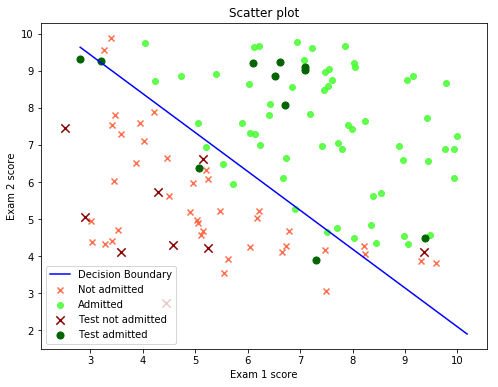

In [49]:
plot_data()
plt.scatter(X_test[:,1][y_test[:, 0] == 0], X_test[:,2][y_test[:, 0] == 0], color='#8B0000', marker = 'x', s=70,
                        alpha=1, label='Test not admitted')
plt.scatter(X_test[:,1][y_test[:, 0] == 1], X_test[:,2][y_test[:, 0] == 1], color='#006400', marker = 'o', s=50,
                        alpha=1, label='Test admitted')
plt.plot(boundary_xs, boundary_ys, 'b-', label='Decision Boundary')
plt.legend()
plt.show()

## 5 Test Logistic Regression on the dating dataset

*This part of the exercise is advanced, you can do it at your own discretion.*

First, we load in the data, which is a cleaned, subset version of the dating dataset you are familiar with.

In [12]:
dating_data = pd.read_csv('data/dating_data.csv', sep = ',', dtype='float')

X_dating = dating_data[['age', 'height', 'income']].values
y_dating = dating_data['status_after_a_month'].values

print('Shape of matrix X_dating is {}.'.format(X_dating.shape))
print('X_dating has {} samples.'.format(X_dating.shape[0]))
print('X_dating has {} features.'.format(X_dating.shape[1]))

y_dating = y_dating.reshape(-1, 1)

print('Shape of vector y_dating is {}.'.format(y_dating.shape))

Shape of matrix X_dating is (8390, 3).
X_dating has 8390 samples.
X_dating has 3 features.
Shape of vector y_dating is (8390, 1).


In [13]:
dating_data.head(5)

age  height   income  status_after_a_month
0  35.0    70.0  80000.0                   1.0
1  23.0    71.0  20000.0                   1.0
2  28.0    72.0  40000.0                   0.0
3  40.0    71.0  60000.0                   1.0
4  22.0    65.0  20000.0                   1.0

We have 3 features: age, height, income that belong to a male person. The target variable is his status after a month. $0$ means no connection, $1$ means at least one connection.

However, as you can see, the features are in different units, with different scale:

- Age is between 18 and 69.

- Height is in inches, between 53 (~140 cm) and 83 (~210 cm)

- Income is in \$, annual income, between \$20,000 and \$1,000,000.


With feature 3 numerically very large compared to the other 2 features, $\theta_3$ might be very small, as well as numerical instabilities might occur.

Thus, we opt to **standardise** the data - scaling it so that each feature is skrunk down to a new set of numbers having mean of 0 and standard deviation of 1.

For example, the range of income (20000, 1000000) becomes (-0.44352, 4.33322) instead. The mapping between feature j and the scaled feature j is retained, to transform it back or to transform new test data.

We can achieve this with the following code:

In [15]:
# Just run this cell
X_dating_mean = np.mean(X_dating, axis=0)    
X_dating_std = np.std(X_dating, axis=0)       # calculating standard deviation
X_dating_scaled = (X_dating - X_dating_mean) / X_dating_std

X_dating_scaled = np.insert(X_dating_scaled, 0, 1, axis=1)

Now we train a logistic regression model again.

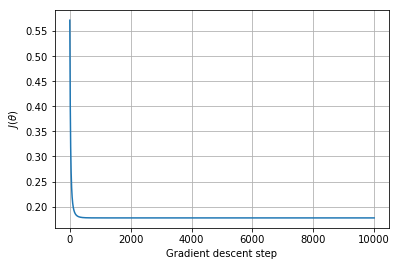

In [30]:
m, n = X_dating_scaled.shape
num_iterations = 10000
learning_rate = 0.1
theta = np.ones((n,1))
cost_history = np.zeros(num_iterations)

for i in range(num_iterations):
    dtheta = calculate_gradient(X_dating_scaled, y_dating, theta)
    theta = theta - learning_rate * dtheta
    cost_history[i] = calculate_cost(X_dating_scaled, y_dating, theta)

theta_dating_optimal = theta.copy()    
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Gradient descent step')
ax.set_ylabel('$J(\\theta)$')
ax.grid(True)
ax.plot(cost_history)
plt.show()

In [34]:
print('The final theta is: \n {}'.format(theta_dating_optimal))

The final theta is: 
 [[ 3.10651144]
 [ 0.08243962]
 [-0.01192599]
 [ 0.10328468]]


You can compared the theta we have with the coefficients from the morning session.

In [33]:
train_accuracy = np.mean(1 - np.abs(predict(X_dating_scaled, theta_dating_optimal) - y_dating))
print('Train accuracy: {} %'.format(train_accuracy * 100))

Train accuracy: 95.68533969010727 %
